<p style="background:#83739E; color:white; font-size: 2.1em; text-align:center"> 
    <br><b>Risk Evaluation for Retail Banks</b><br>
    <br>Exploratory Data Analysis - Applications<br><br> 
</p>

<p style="text-align: right;">Module 4: Machine Learning<br>
Sprint 4: Machine Learning Capstone Project<br>
Author : Renato Mariano</p>

<h1 style="color:#774CAD">Introduction </h1>

Welcome to the Capstone Project of of the Machine Learning Module! In this sprint, we embark on an exciting journey to develop a **risk evaluation service for retail banks**, leveraging the power of data science and machine learning.

**Project Context**

The objective is to iteratively build and implement a plan for a large dataset based on business objectives. The dataset, sourced from Home Credit Group (download at: https://storage.googleapis.com/341-home-credit-default/home-credit-default-risk.zip ; description at:https://storage.googleapis.com/341-home-credit-default/Home%20Credit%20Default%20Risk.pdf), serves as the foundation for this exploration.

The context is driven by a startup idea, co-developed with a team member responsible for sales and operations. The focus is on providing risk evaluation as a service for retail banks. Machine learning is identified as a crucial component to capture statistical patterns in loan defaults. The **objective is to create a proof-of-concept (POC) product by building diverse models and deploying the best**, aligning with potential client needs.

**What We Aim to Achieve**:

- **Translate Business Requirements into Data Science Tasks**.

- **Exploration**: We will delve into the dataset to extract valuable insights and prepare the data for further analysis.

- **Understanding Data**: We will conduct an Exploratory Data Analysis (EDA) to uncover the underlying characteristics of the dataset and explore relationships between variables.

- **Statistical Insight**: Our journey will include statistical inference to test hypotheses related to the rejected loan applications.

- **Machine Learning Models**: We will develop and refine machine learning models designed to predict whether a loan application is accepted or rejected.

- **Real-world Deployment**: Our final goal is to deploy the best-performing machine learning model on Google Cloud Platform for practical, real-world usage.

- **Recommendations**: Throughout our exploration, we will provide valuable insights and recommendations to enhance our analysis and model performance.

<h2 style="color:#774CAD">Library Imports and Notebook Setup</h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from time import time
from rapidfuzz import process
import os
import gc

from utils import utils
from utils import EDA

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from feature_engine.imputation import CategoricalImputer
from scipy.stats import chi2_contingency, pointbiserialr


In [2]:
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%load_ext blackcellmagic

from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h2 style="color:#774CAD">Entity-Relationship Diagram</h2>

The following entity diagram shows the encompassed dataframes. They will be explored in more details during in the next sections of this notebook.

<img src="images/00_entity-relationship_diagram.PNG" width=850>

These dataframes can be found under the following directory. We also have access to a description of the features in each dataframe (HomeCredit_columns_description.csv).

In [3]:
for file in os.listdir(r"data/home-credit-default-risk"):
    print(file)

application_test.csv
application_train.csv
bureau.csv
bureau_balance.csv
credit_card_balance.csv
HomeCredit_columns_description.csv
installments_payments.csv
POS_CASH_balance.csv
previous_application.csv
sample_submission.csv


The columns description will be imported into the next dataframe and shown whenever some understanding of the features' content is required.

In [4]:
col_info = utils.load_df(file_path="data\home-credit-default-risk\HomeCredit_columns_description.csv", encoding='unicode_escape')

The shape of the data is: (219, 5)
load_df took 0.020 seconds



<h1 style="color:#774CAD">Application Data</h1>

We start our exploration with our **test and train sets** for the main dataframe (**Application data**).

Here, **every loan has its own row and are identified by the SK_ID_CURR**. As we can see bellow, **the test dataset does not contain our TARGET** and although can be used to make predictions, we will not be able to check how good we did on this test data.

In [5]:
print("APPLICATION DATA - TEST")
df_test = utils.load_df(file_path="data/home-credit-default-risk/application_test.csv")
df_test.head(3)

APPLICATION DATA - TEST


The shape of the data is: (48744, 121)
load_df took 0.867 seconds



,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.000,568800.000,20560.500,450000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
1,100005,Cash loans,M,N,Y,0,99000.000,222768.000,17370.000,180000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,3.000
2,100013,Cash loans,M,Y,Y,0,202500.000,663264.000,69777.000,630000.000,...,0,0,0,0,0.000,0.000,0.000,0.000,1.000,4.000


In [6]:
print("APPLICATION DATA - TRAIN")
df = utils.load_df(file_path="data/home-credit-default-risk/application_train.csv")
df.head(3)

APPLICATION DATA - TRAIN
The shape of the data is: (307511, 122)
load_df took 4.905 seconds



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.000,406597.500,24700.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,1.000
1,100003,0,Cash loans,F,N,N,0,270000.000,1293502.500,35698.500,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000
2,100004,0,Revolving loans,M,Y,Y,0,67500.000,135000.000,6750.000,...,0,0,0,0,0.000,0.000,0.000,0.000,0.000,0.000


Both dataframes contains the same features except the TARGET. The training data presents **122 features and about 307_511 rows** with loans. **Most of our features are presented as numerical**, with **16 categorical** features. Some of the integer features can be also seen as categories.

A brief description of the features:

**Client Information**:

- SK_ID_CURR, **TARGET**: ID and target variable indicating payment difficulties.
- NAME_CONTRACT_TYPE, CODE_GENDER: Loan type and client gender.
- FLAG_OWN_CAR, FLAG_OWN_REALTY: Ownership of car and house.
- CNT_CHILDREN, AMT_INCOME_TOTAL, AMT_CREDIT, AMT_ANNUITY, AMT_GOODS_PRICE: Family details and loan amounts.

**Personal and Socio-demographic Information**:

- NAME_TYPE_SUITE, NAME_INCOME_TYPE, NAME_EDUCATION_TYPE, NAME_FAMILY_STATUS, NAME_HOUSING_TYPE.

**Location and Time Information**:

- REGION_POPULATION_RELATIVE, DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH: Client's location and age details.

**Building Information**:

- OWN_CAR_AGE: Age of the client's car.
- Columns 47 to 93: Various features providing normalized information about the building where the client lives, including apartment size, age of the building, number of elevators, etc.

**Contact and Communication**:

- FLAG_MOBIL, FLAG_EMP_PHONE, FLAG_WORK_PHONE, FLAG_CONT_MOBILE, FLAG_PHONE, FLAG_EMAIL, OCCUPATION_TYPE, CNT_FAM_MEMBERS: Contact and occupation details.

**Rating and Timing Information**:

- REGION_RATING_CLIENT, REGION_RATING_CLIENT_W_CITY, WEEKDAY_APPR_PROCESS_START, HOUR_APPR_PROCESS_START: Region rating and application timing.

**Address Matching Flags**:
- Columns 37 to 42: Flags indicating if the client's address matches the contact or work address at region or city levels.

**Other Features**:
- Columns 43 to 93:  Various features related to the building, external scores, documents provided, and requests to Credit Bureau.

<h2 style="color:#774CAD">Assessing the Necessity of Implementing This Model</h2>

In order to analyze the necessity of this model, we first need to evaluate **what proportion of money is given to defaulters**. Let's start with de distribution of this defaulters and then jump into the credit amounts given to them.

Our defaulters are expressed as our **TARGET column**. As explained in the metadata, **this features shows if a client has presented difficulties to pay their loans** or not.

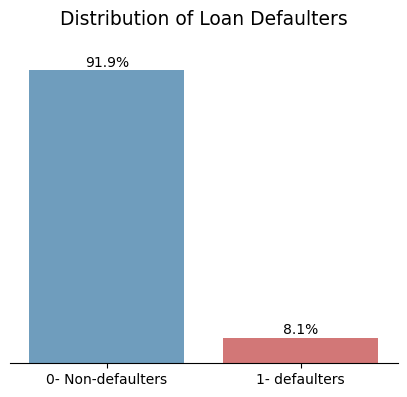

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
sns.countplot(data=df, x="TARGET", ax=ax, palette=['tab:blue', 'tab:red'], alpha=0.7)

total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01 * total, f'{height/total:.1%}', ha='center')

ax.set(ylabel="", xlabel="")
ax.set_yticklabels("")
ax.tick_params(axis='y',length=0)
ax.set_title("Distribution of Loan Defaulters\n", fontsize=13.5)
ax.set_xticks(ticks=[0, 1], labels=["0- Non-defaulters", "1- defaulters"])

sns.despine(left=True)

As we can see, our target (Loan Defaulters) variable is very **unevenly distributed** - about 92% of the client have payed their loans without any delay.

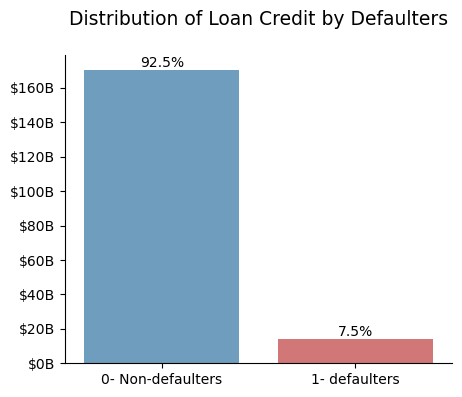

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

amt_credit = amt_credit = pd.DataFrame(df.groupby('TARGET')['AMT_CREDIT'].sum())
sns.barplot(data=amt_credit, x="TARGET", y="AMT_CREDIT", ax=ax, palette=['tab:blue', 'tab:red'], alpha=0.7)

total = amt_credit["AMT_CREDIT"].sum()
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.01 * total, f'{height/total:.1%}', ha='center')

ax.set(ylabel="", xlabel="")
ax.set_title("Distribution of Loan Credit by Defaulters\n", fontsize=13.5)
ax.set_xticks(ticks=[0, 1], labels=["0- Non-defaulters", "1- defaulters"])

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"${x/1e9:.0f}B"))

sns.despine()

In [9]:
print(f"The total credit amount provided to clients on this dataframe is {df['AMT_CREDIT'].sum():,.0f} USD.\n")

print(f"{df.groupby('TARGET')['AMT_CREDIT'].sum()[1]:,.0f} USD were given to defaulters.")
print(f"Which represents {(df.groupby('TARGET')['AMT_CREDIT'].sum()*100 / df['AMT_CREDIT'].sum())[1]:,.1f}% of the total.\n")

The total credit amount provided to clients on this dataframe is 184,207,084,196 USD.

13,846,851,950 USD were given to defaulters.
Which represents 7.5% of the total.



In examining the dataset, it becomes evident that approximately **$184 billion was disbursed in credit**. Notably, **around $13 billion, equivalent to approximately 7.5% of the total credit extended, was allocated to clients who eventually defaulted**. This observation underscores the **necessity for an automated system** capable of identifying defaulters accurately. Traditional methods employed by the bank seem insufficient to capture these nuances effectively, emphasizing the need for more sophisticated approaches in credit risk assessment.

<h2 style="color:#774CAD">Data Separation</h2>

Due to this **deficit of TARGET** variable on the test data, we will **no further use this dataset** and we will **separate our training data into train and test sets**.

We have allocated 50% of the data for training. 20% for validation and the remaining 30% for the test of the final model.

In [10]:
train_size = 0.5
val_size = 0.4

df_train, df_temp = train_test_split(df, test_size=(1 - train_size), random_state=1)
df_valid, df_test = train_test_split(df_temp, test_size=(1 - val_size), random_state=1)

print(df_train.shape, df_test.shape, df_valid.shape)

(153755, 122) (92254, 122) (61502, 122)


As a sanity check for the further development of this work, we will **check if the values in the categorical features are presented in all datasets**. If some of this values are not common to all, we can have problems on our data pipelines due to processes like One-Hot-Encoding.

In [11]:
cat_feats =  df_train.select_dtypes(include="O").columns

In [12]:
for col in cat_feats:
    train_values = df_train[col].value_counts().sort_index().index
    test_values = df_test[col].value_counts().sort_index().index

    if train_values.equals(test_values):
        print(f"'{col}' are the same")
    else:
        print(f"'{col}' are DIFFERENT")

'NAME_CONTRACT_TYPE' are the same
'CODE_GENDER' are the same
'FLAG_OWN_CAR' are the same
'FLAG_OWN_REALTY' are the same
'NAME_TYPE_SUITE' are the same
'NAME_INCOME_TYPE' are the same
'NAME_EDUCATION_TYPE' are the same
'NAME_FAMILY_STATUS' are DIFFERENT
'NAME_HOUSING_TYPE' are the same
'OCCUPATION_TYPE' are the same
'WEEKDAY_APPR_PROCESS_START' are the same
'ORGANIZATION_TYPE' are the same
'FONDKAPREMONT_MODE' are the same
'HOUSETYPE_MODE' are the same
'WALLSMATERIAL_MODE' are the same
'EMERGENCYSTATE_MODE' are the same


Comparing Train and Test set, all categorical values present the same groups.

In [13]:
for col in cat_feats:
    train_values = df_train[col].value_counts().sort_index().index
    valid_values = df_valid[col].value_counts().sort_index().index

    if train_values.equals(valid_values):
        print(f"'{col}' are the same")
    else:
        print(f"'{col}' are DIFFERENT")

'NAME_CONTRACT_TYPE' are the same
'CODE_GENDER' are DIFFERENT
'FLAG_OWN_CAR' are the same
'FLAG_OWN_REALTY' are the same
'NAME_TYPE_SUITE' are the same
'NAME_INCOME_TYPE' are the same
'NAME_EDUCATION_TYPE' are the same
'NAME_FAMILY_STATUS' are DIFFERENT
'NAME_HOUSING_TYPE' are the same
'OCCUPATION_TYPE' are the same
'WEEKDAY_APPR_PROCESS_START' are the same
'ORGANIZATION_TYPE' are the same
'FONDKAPREMONT_MODE' are the same
'HOUSETYPE_MODE' are the same
'WALLSMATERIAL_MODE' are the same
'EMERGENCYSTATE_MODE' are the same


When we look at the Train versus Validation we see there is discrepancy between the **values of Gender and Family_Status are different**. We will have this in mind during the exploration and modeling.

Now we export our datasets, clean some of the memory and we can further explore our training set.

In [14]:
# df_train.to_csv("data/df_train.csv", index=False)
# df_test.to_csv("data/df_test.csv", index=False)
# df_valid.to_csv("data/df_validation.csv", index=False)

In [15]:
del df, df_test, df_valid, df_temp
gc.collect()

4124

<h2 style="color:#774CAD">Further Exploration</h2>

In [16]:
df_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

We make a quick **check for duplicates** on the dataset and **get custom information** for our features with the help of a custom function.

In [17]:
df_train[df_train.duplicated()].shape

(0, 122)

In [18]:
df_info = EDA.custom_info(df_train)
df_info[df_info["dtype"] == "object"].drop(["Min", "Mean", "Max", "Std"], axis=1)

Shape: (153755, 122)



,dtype,%Nulls,#Unique,top_values,top_counts,top_ratios
NAME_CONTRACT_TYPE,object,0.000,2,"['Cash loans', 'Revolving loans']","[138975, 14780]","[0.9, 0.1]"
CODE_GENDER,object,0.000,3,"['F', 'M', 'XNA']","[101110, 52643, 2]","[0.66, 0.34, 0.0]"
FLAG_OWN_CAR,object,0.000,2,"['N', 'Y']","[101449, 52306]","[0.66, 0.34]"
FLAG_OWN_REALTY,object,0.000,2,"['Y', 'N']","[106750, 47005]","[0.69, 0.31]"
NAME_TYPE_SUITE,object,0.421,7,"['Unaccompanied', 'Family', 'Spouse, partner',...","[124261, 20058, 5686, 1618, 912]","[0.81, 0.13, 0.04, 0.01, 0.01]"
NAME_INCOME_TYPE,object,0.000,8,"['Working', 'Commercial associate', 'Pensioner...","[79419, 35780, 27764, 10765, 12]","[0.52, 0.23, 0.18, 0.07, 0.0]"
NAME_EDUCATION_TYPE,object,0.000,5,"['Secondary / secondary special', 'Higher educ...","[109132, 37457, 5161, 1919, 86]","[0.71, 0.24, 0.03, 0.01, 0.0]"
NAME_FAMILY_STATUS,object,0.000,6,"['Married', 'Single / not married', 'Civil mar...","[98302, 22657, 14904, 9975, 7915]","[0.64, 0.15, 0.1, 0.06, 0.05]"
NAME_HOUSING_TYPE,object,0.000,6,"['House / apartment', 'With parents', 'Municip...","[136448, 7463, 5574, 2393, 1334]","[0.89, 0.05, 0.04, 0.02, 0.01]"
OCCUPATION_TYPE,object,31.369,18,"['Laborers', 'Sales staff', 'Core staff', 'Man...","[27552, 16123, 13883, 10742, 9297]","[0.18, 0.1, 0.09, 0.07, 0.06]"


The dataset **does not present any duplicates**.

This description shows that 90% of the contracts are **cash loans**. Most clients are **females** (66%), people who **did not flag their own car** (66%), but who **flagged having a house** (69%), and with **income from working** (52%).

In [19]:
pd.set_option('display.max_rows', 130)

print("Output with only 10 top and 10 bottom values.")
df_info[df_info["dtype"] == "float64"].iloc[np.r_[0:10, -10:0]]

Output with only 10 top and 10 bottom values.


,dtype,%Nulls,#Unique,Min,Mean,Max,Std,top_values,top_counts,top_ratios
AMT_INCOME_TOTAL,float64,0.000,1569,25650.000,168401.380,18000090.000,113350.149,"[135000.0, 112500.0, 157500.0, 180000.0, 90000.0]","[17900, 15500, 13423, 12387, 11257]","[0.12, 0.1, 0.09, 0.08, 0.07]"
AMT_CREDIT,float64,0.000,4647,45000.000,598461.762,4050000.000,402025.290,"[450000.0, 675000.0, 225000.0, 270000.0, 18000...","[4785, 4488, 4043, 3670, 3655]","[0.03, 0.03, 0.03, 0.02, 0.02]"
AMT_ANNUITY,float64,0.005,11939,1980.000,27089.272,258025.500,14509.411,"[9000.0, 13500.0, 6750.0, 10125.0, 37800.0]","[3190, 2790, 1187, 1076, 800]","[0.02, 0.02, 0.01, 0.01, 0.01]"
AMT_GOODS_PRICE,float64,0.092,722,45000.000,537895.313,4050000.000,369011.921,"[450000.0, 225000.0, 675000.0, 900000.0, 27000...","[12944, 12578, 12542, 7629, 5805]","[0.08, 0.08, 0.08, 0.05, 0.04]"
REGION_POPULATION_RELATIVE,float64,0.000,80,0.001,0.021,0.073,0.014,"[0.035792, 0.04622, 0.030755, 0.025164, 0.026392]","[8342, 6582, 6120, 5991, 5773]","[0.05, 0.04, 0.04, 0.04, 0.04]"
DAYS_REGISTRATION,float64,0.000,14749,-22928.000,-4988.151,0.000,3525.781,"[-1.0, -7.0, -6.0, -5.0, -3.0]","[60, 52, 48, 48, 47]","[0.0, 0.0, 0.0, 0.0, 0.0]"
OWN_CAR_AGE,float64,65.983,55,0.000,12.060,65.000,11.858,"[7.0, 6.0, 3.0, 2.0, 8.0]","[3705, 3190, 3123, 2962, 2943]","[0.02, 0.02, 0.02, 0.02, 0.02]"
CNT_FAM_MEMBERS,float64,0.001,16,1.000,2.153,16.000,0.911,"[2.0, 1.0, 3.0, 4.0, 5.0]","[79287, 33826, 26284, 12367, 1707]","[0.52, 0.22, 0.17, 0.08, 0.01]"
EXT_SOURCE_1,float64,56.522,61708,0.015,0.503,0.963,0.211,"[0.8141545954597482, 0.4921053720143893, 0.543...","[4, 4, 4, 4, 4]","[0.0, 0.0, 0.0, 0.0, 0.0]"
EXT_SOURCE_2,float64,0.201,85763,0.000,0.514,0.855,0.191,"[0.2858978721410488, 0.2622583692422573, 0.265...","[356, 218, 171, 168, 148]","[0.0, 0.0, 0.0, 0.0, 0.0]"


As we observe the values for our continuous variables, we see that the values for the **variables begining with "DAYS_" are negative**. Besides, we can already grasp an idea about the **location of null values in the dataset**.

We expect that **values like 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE' should help the prediction of defaulters**. Let's evaluate if this holds true in the next notebooks.

In [20]:
df_info[(df_info["dtype"] == "int64")][:-18] # Hide some of the Flag documents

,dtype,%Nulls,#Unique,Min,Mean,Max,Std,top_values,top_counts,top_ratios
SK_ID_CURR,int64,0.000,153755,100002.000,278514.854,456255.000,102754.672,"[115145, 318929, 178471, 245243, 178314]","[1, 1, 1, 1, 1]","[0.0, 0.0, 0.0, 0.0, 0.0]"
TARGET,int64,0.000,2,0.000,0.081,1.000,0.273,"[0, 1]","[141334, 12421]","[0.92, 0.08]"
CNT_CHILDREN,int64,0.000,14,0.000,0.417,14.000,0.723,"[0, 1, 2, 3, 4]","[107713, 30533, 13374, 1840, 224]","[0.7, 0.2, 0.09, 0.01, 0.0]"
DAYS_BIRTH,int64,0.000,17259,-25229.000,-16038.506,-7673.000,4367.126,"[-11588, -13217, -11524, -11285, -13634]","[25, 24, 24, 24, 23]","[0.0, 0.0, 0.0, 0.0, 0.0]"
DAYS_EMPLOYED,int64,0.000,10931,-17912.000,64012.748,365243.000,141435.272,"[365243, -212, -199, -384, -207]","[27768, 80, 78, 77, 76]","[0.18, 0.0, 0.0, 0.0, 0.0]"
DAYS_ID_PUBLISH,int64,0.000,6059,-7197.000,-2991.139,0.000,1510.692,"[-4109, -4214, -4171, -4336, -4438]","[89, 88, 85, 85, 85]","[0.0, 0.0, 0.0, 0.0, 0.0]"
FLAG_MOBIL,int64,0.000,2,0.000,1.000,1.000,0.003,"[1, 0]","[153754, 1]","[1.0, 0.0]"
FLAG_EMP_PHONE,int64,0.000,2,0.000,0.819,1.000,0.385,"[1, 0]","[125984, 27771]","[0.82, 0.18]"
FLAG_WORK_PHONE,int64,0.000,2,0.000,0.200,1.000,0.400,"[0, 1]","[123024, 30731]","[0.8, 0.2]"
FLAG_CONT_MOBILE,int64,0.000,2,0.000,0.998,1.000,0.044,"[1, 0]","[153453, 302]","[1.0, 0.0]"


We can also graphically evaluate the distribution of null values.

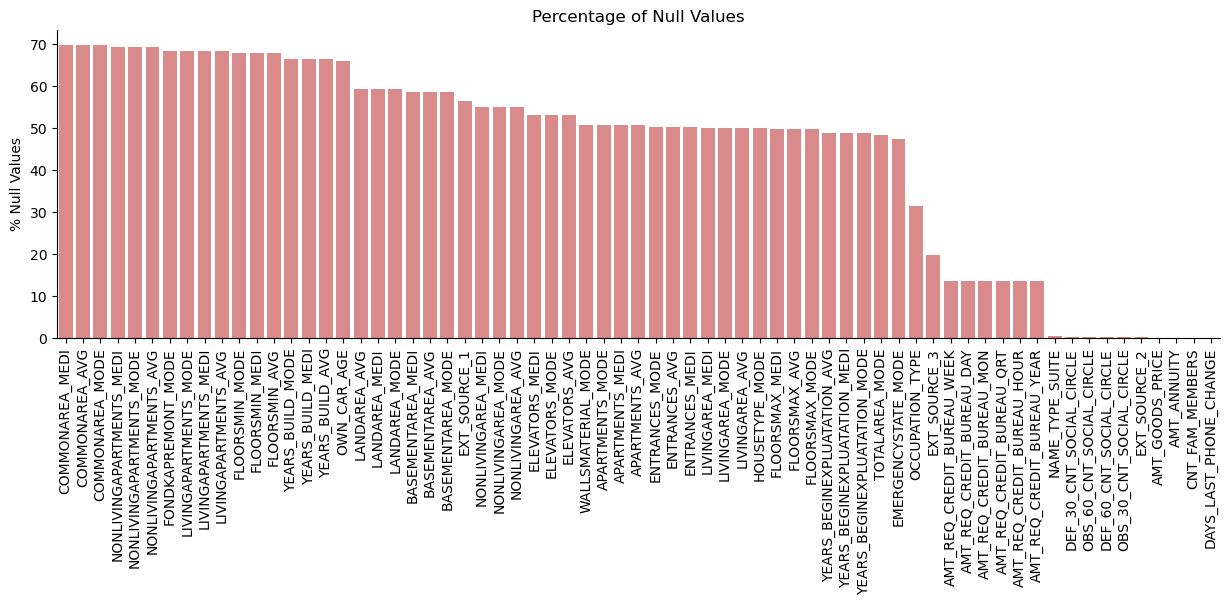

In [21]:
missing_df = pd.DataFrame(df_info[df_info["%Nulls"] > 0]["%Nulls"].sort_values(ascending=False))

fig, ax = plt.subplots(figsize=(15, 4))
sns.barplot(
    data=missing_df,
    y="%Nulls",
    x=missing_df.index,
    color="tab:red",
    alpha=0.6,
    ax=ax,
)
ax.set(ylabel="% Null Values", xlabel="", title="Percentage of Null Values")
sns.despine()
plt.xticks(rotation=90);

The columns with the **greatest percentage of missing values** are primarily related to detailed information about the **client's living space**, such as apartment features, common areas, and building characteristics. **Additionally**, attributes like the client's **car age, material of the walls, and certain external scores** show significant missing data. 

These columns may require **careful handling** before building our machine learning models. Some Boosting models like XGBoost can handle missing values with no need for imputation. Another option available is also to drop columns with a threshold percentage of null values. For now, **we will further evaluate to see which method best adapt to our needs**.

<h2 style="color:#774CAD">Univariate Analysis of Features</h2>

To gain a rapid insight into this feature-rich dataset, we will create countplots/histograms for a majority of its features, commencing with the object-type features.

Here, we start by taking a look at the distribution of the features that can possibily generate a problem during One-Hot-Encoding (**Gender and Family_Status**). The groups not belonging to the validation set are XNA and UNKOWN, respectively; they have a very low percentage (close to 0%), but will not be present for the application of our pipelines.

Most of these categories are self-explained, but we can talk a little about the **types of contracts**:
- Cash Loan: One-time disbursement of funds with a fixed repayment schedule.
- Revolving Loan: borrowers access a line of credit up to a predetermined limit.

**Organization Types** also present different types of organizations with different number on the end. We will create a custom transformer to group similar organizations!

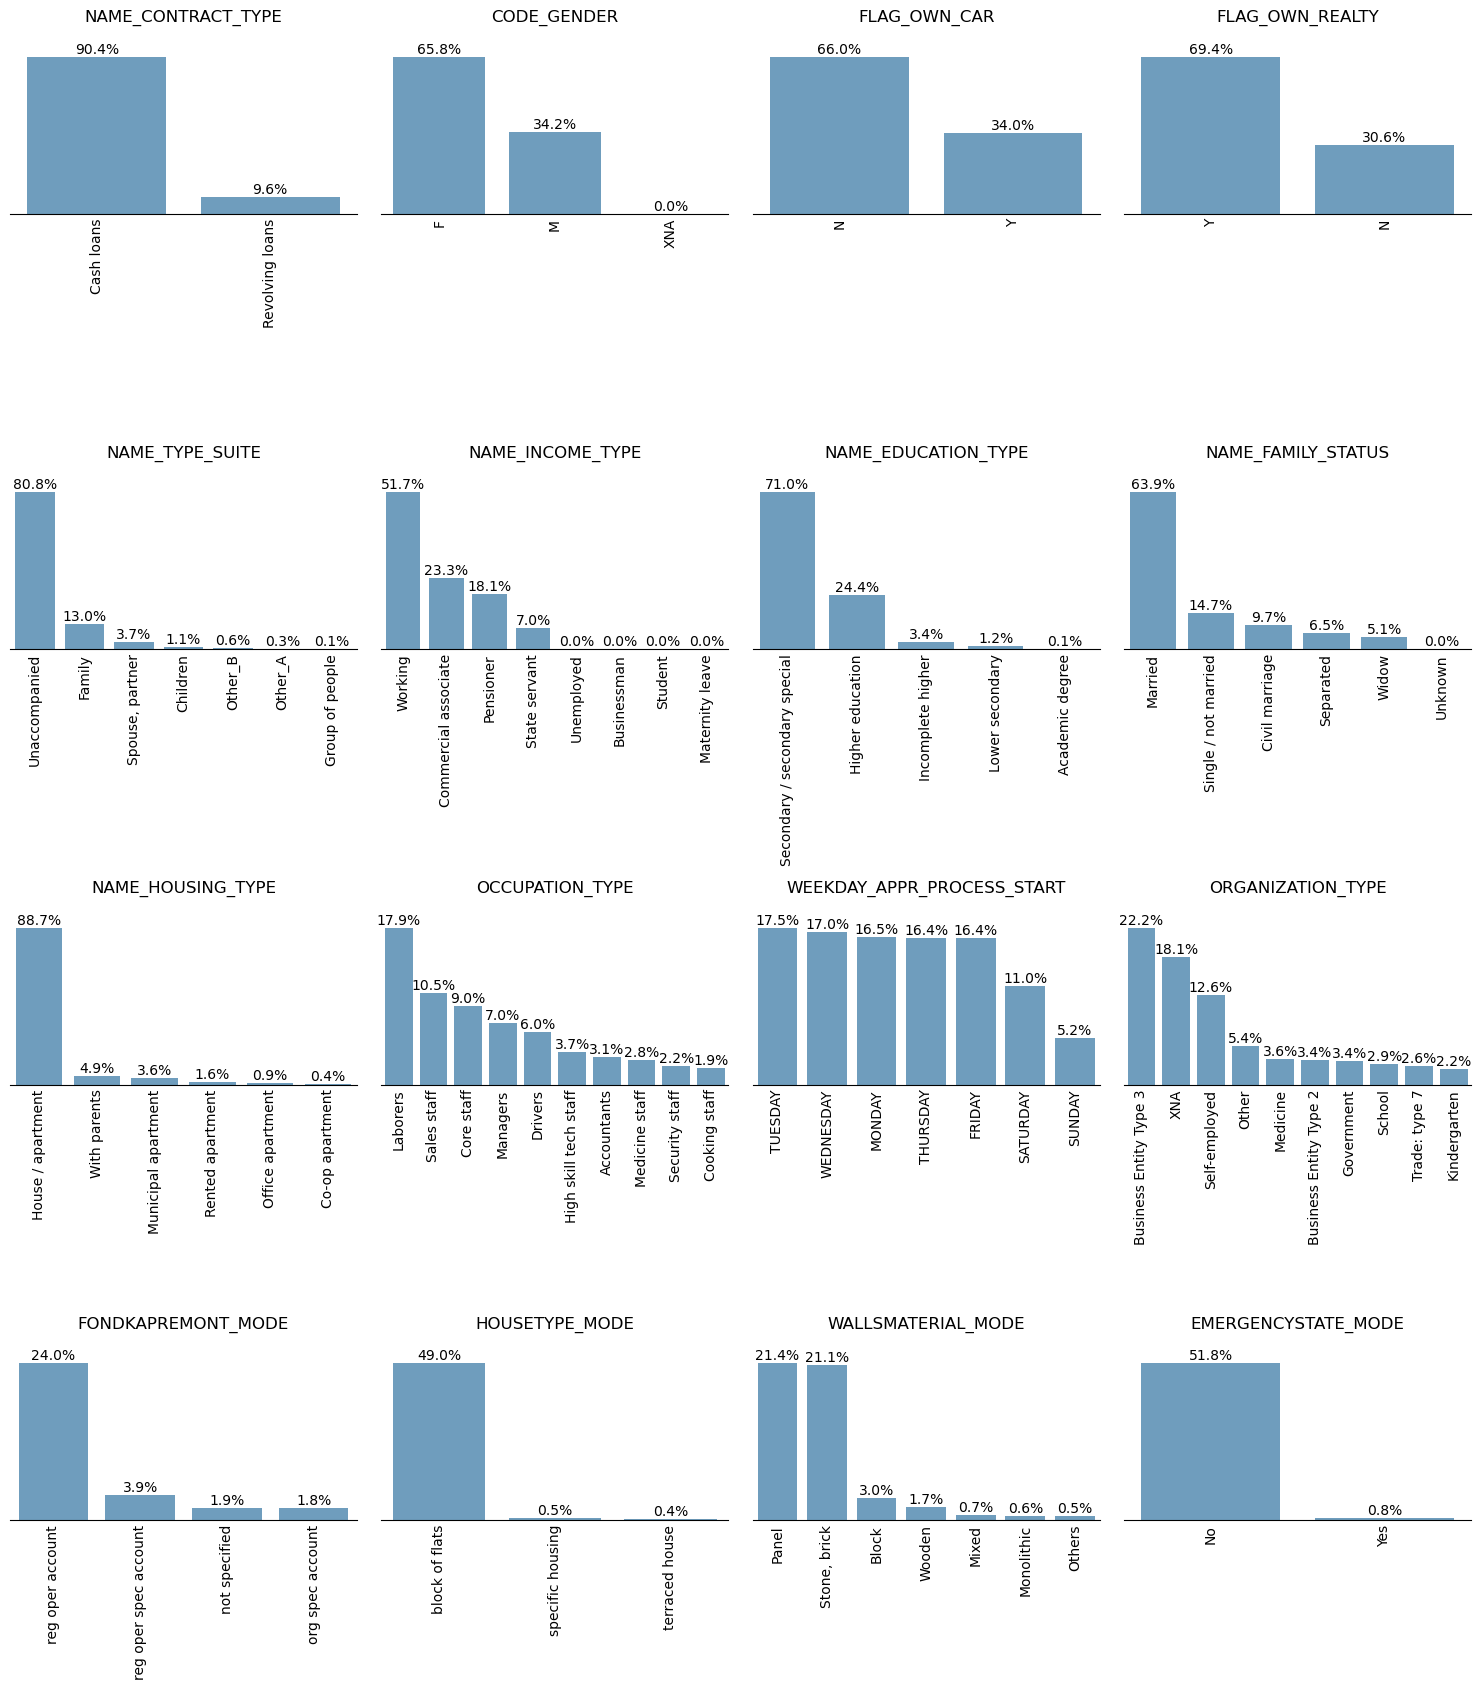

In [22]:
cat_feats = df_train.select_dtypes(include="object").columns
EDA.plot_categories(df_train, cat_feats, fig_x=15, fig_y=17, top_n=10)

For the **integer features**, there is also not much to talk about and the plots are self-explanatory.

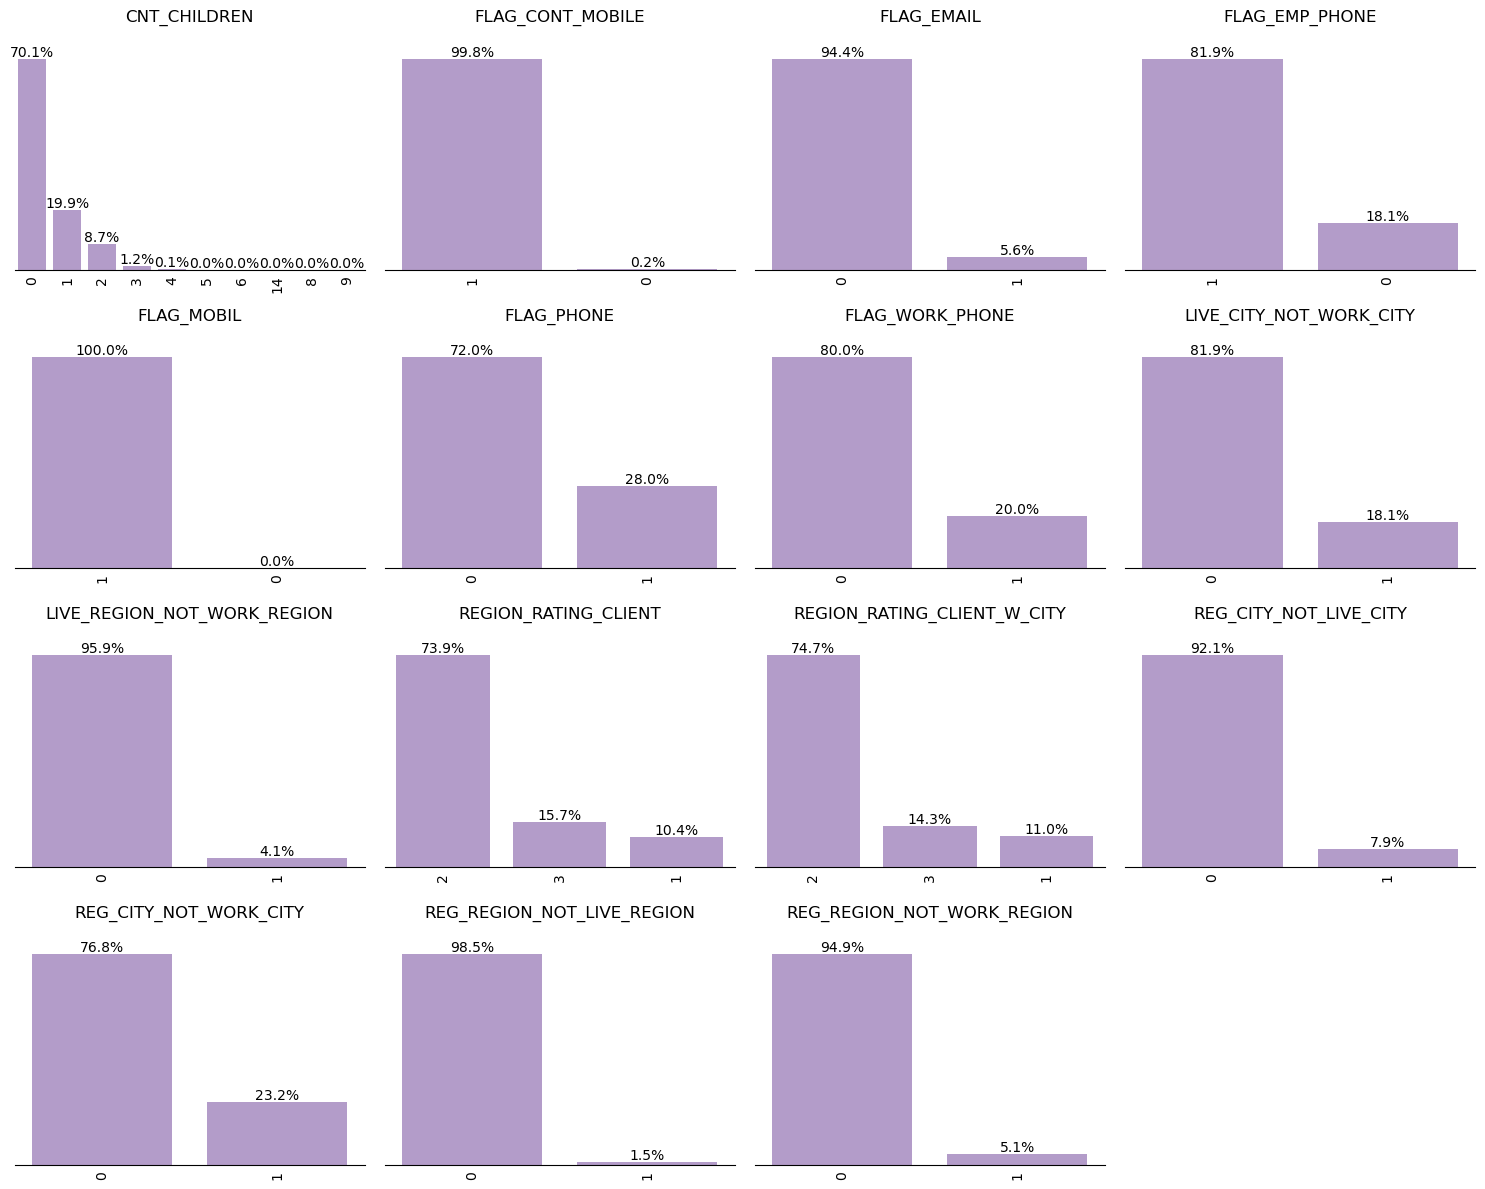

In [23]:
int_feats = df_info[(df_info["dtype"] == "int64")]["dtype"].index
int_feats_cleaned = int_feats[:21].difference(['SK_ID_CURR', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED', 'HOUR_APPR_PROCESS_START', 'TARGET'])
EDA.plot_categories(df_train, int_feats_cleaned, fig_x=15, fig_y=12, top_n=10, color='tab:purple')

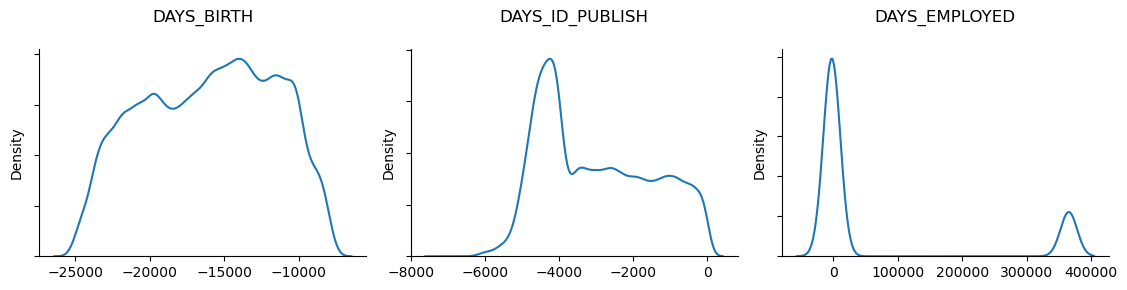

In [24]:
EDA.plot_continuous(df_train, ['DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED'], fig_x=15, fig_y=3, color='tab:green')

Here we show our **continuous features**, we see that most of them present very high outliers. It is a good visulization also for the normalized external sources.

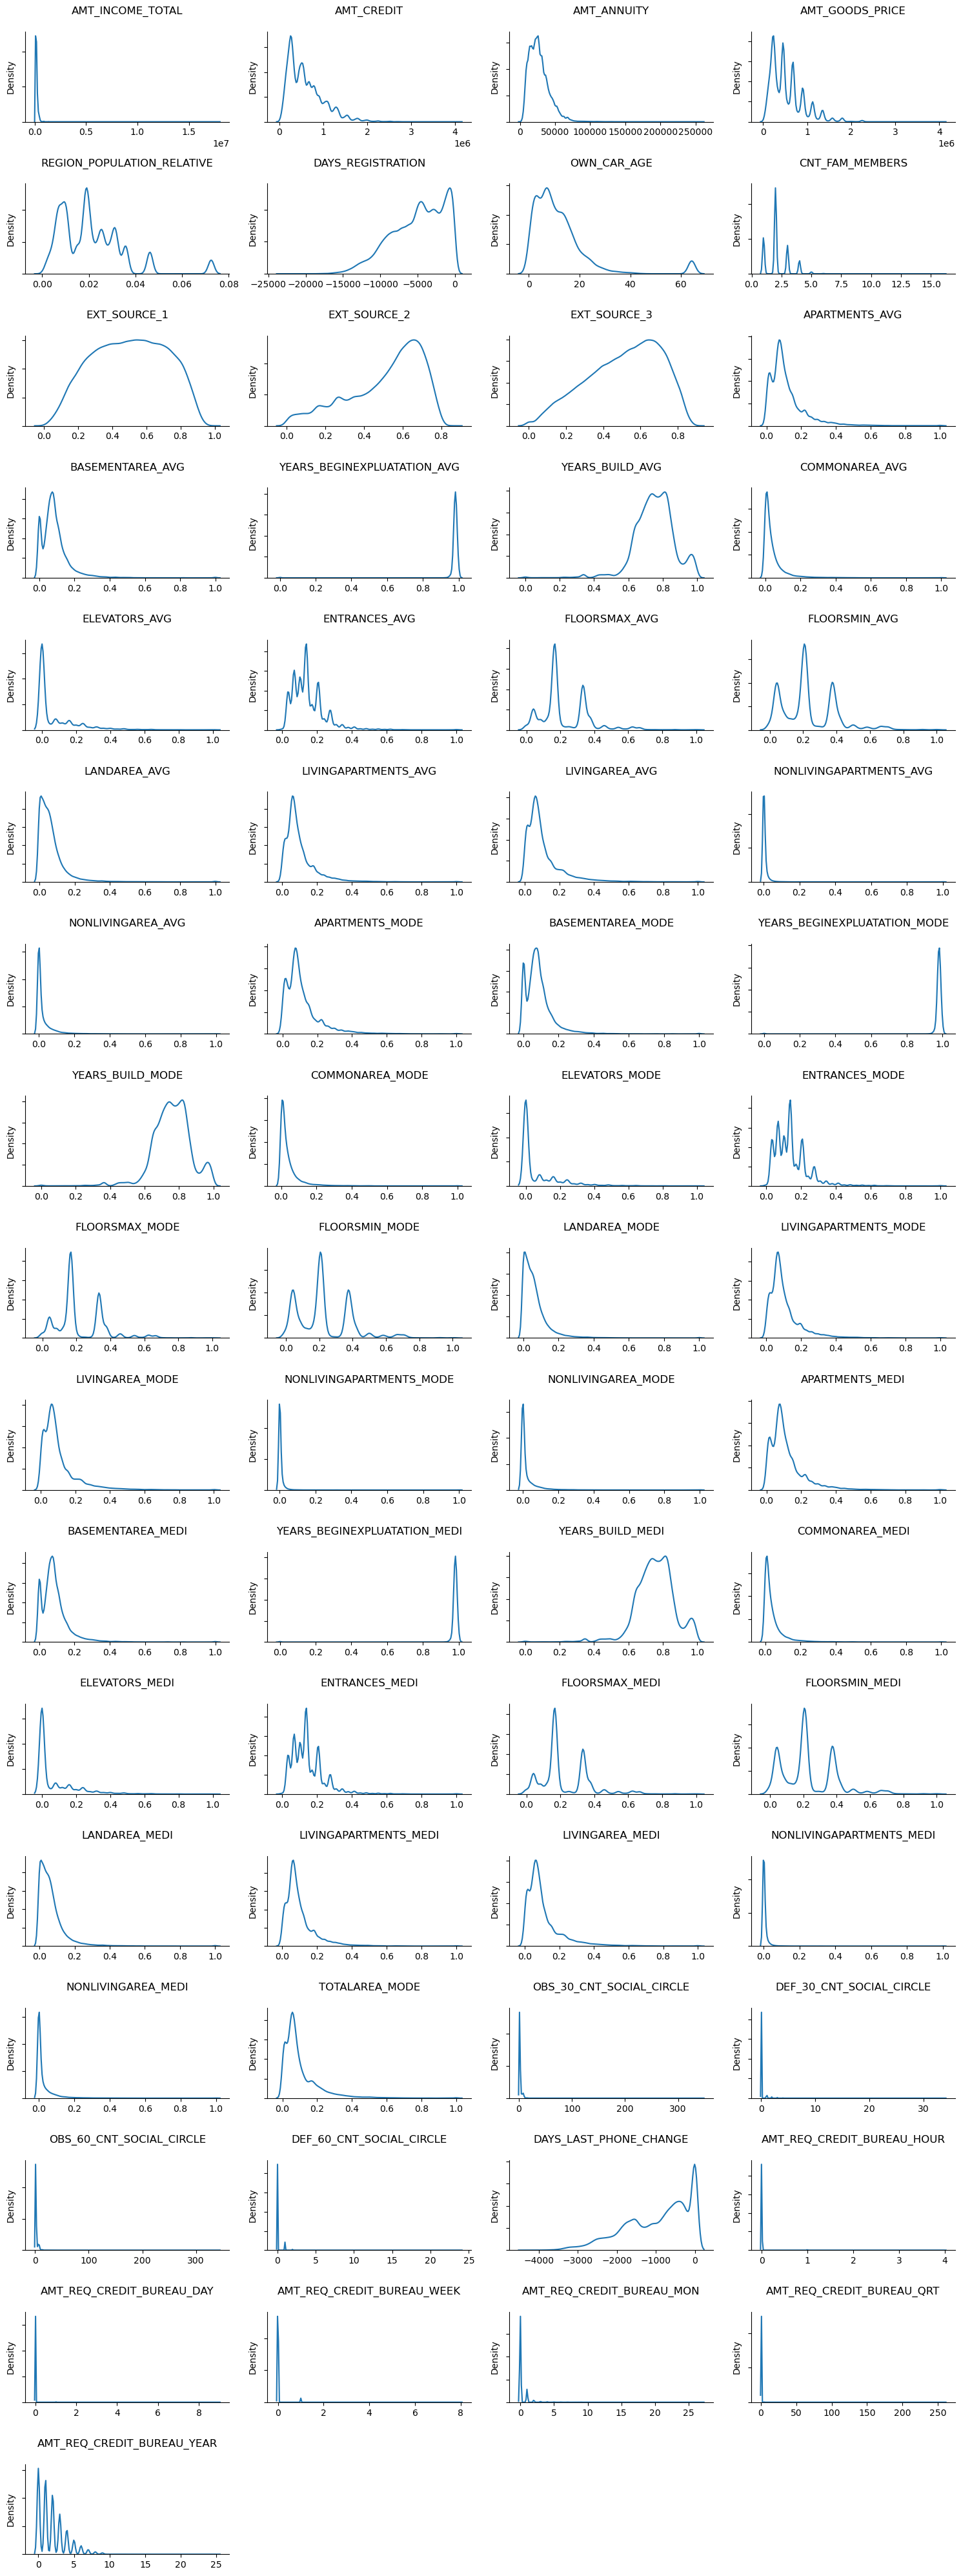

In [25]:
cont_feats = df_info[(df_info["dtype"] == "float64")]["dtype"].index

EDA.plot_continuous(df_train, cont_feats, fig_x=15, fig_y=40, color='tab:green')

<h2 style="color:#774CAD">Outliers</h2>

To check the outliers on this dataset, we will numerically evaluate the **skweness of the distributions**. The calculation is made subtracting the mode from a mean and then dividing the difference by standard deviation. We will not show values for the FLAG columns (binary).

In [26]:
num_feats = df_train.select_dtypes(include="number").columns[~df_train.select_dtypes(include="number").columns.str.contains('FLAG')]
skew_info = df_train[num_feats].skew().sort_values(ascending=False)
print(
    f"The number of features with skewness higher than |1| is {skew_info[(skew_info > 1) | (skew_info > -1)].count()} out of {skew_info.size}"
)

The number of features with skewness higher than |1| is 76 out of 80


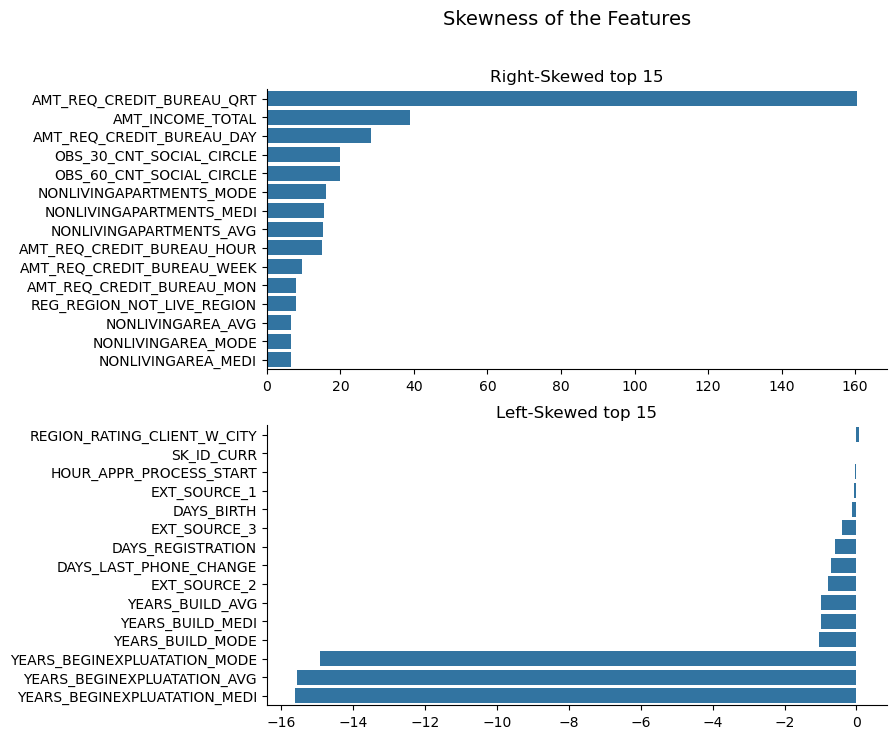

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex= False)

sns.barplot(data=skew_info.head(15), orient="h", ax=axes[0])
sns.barplot(data=skew_info.tail(15), orient="h", ax=axes[1])

plt.suptitle("Skewness of the Features", fontsize=14)
axes[0].set(title="Right-Skewed top 15")
axes[1].set(title="Left-Skewed top 15")

for ax in axes:
    ax.set(xlabel="")
    sns.despine()

In general terms, all the **numerical data is very skewed** (76 out 80 features with skewness > |1|).

We see that the distribution of **Income and amount requested is very right-skewed** and contains outliers. This is something that should be **expected**.

In the **left-skeweness side**, the last 3 rows represent **normalized information about building where the client lives**.** The histogram bellow shows the distribution of the most left-skewed features.

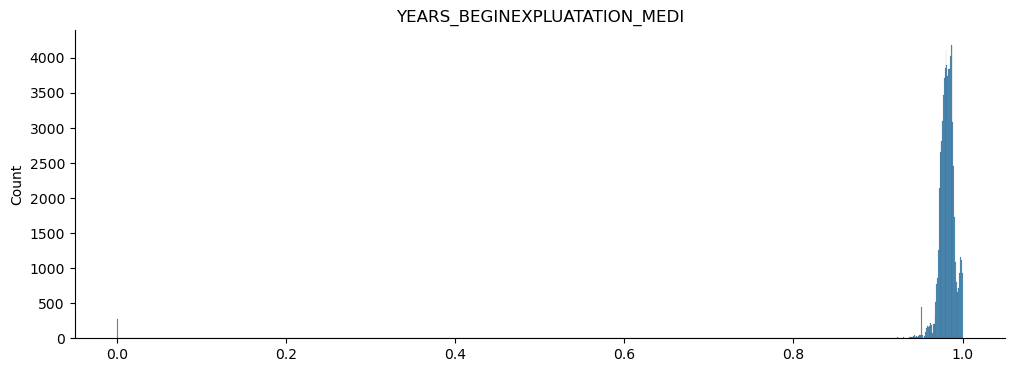

In [28]:
fig, ax= plt.subplots(1, 1, figsize=(12, 4))

sns.histplot(df_train['YEARS_BEGINEXPLUATATION_MEDI'], ax=ax, bins=1000)
ax.set(xlabel="", title="YEARS_BEGINEXPLUATATION_MEDI")
sns.despine()

The **0 values** in them are **not explained** in the metadata, and it is not clear what they mean, however it is clear that **they DO NOT FLAG having A HOUSE** (see table bellow histogram).

The best solution in these cases seems to **treat them as null values**.

In [29]:
df_train[df_train['YEARS_BEGINEXPLUATATION_MEDI'] == 0][['FLAG_OWN_REALTY', 'YEARS_BEGINEXPLUATATION_MEDI']].head()

,FLAG_OWN_REALTY,YEARS_BEGINEXPLUATATION_MEDI
191929,Y,0.000
233771,Y,0.000
278117,Y,0.000
25078,Y,0.000
228034,N,0.000


<h2 style="color:#774CAD">Correlation of Features</h2>

<h3 style="color:#774CAD">Categorical</h3>

Let's take a look at how the features are the correlated. Before showing the heatmap, we run a simple label enconder on the features.

<h4 style="color:#774CAD">Encoding</h4>

Some variables were defined with the columns for different types of data. Here we define one which will store all the categorical columns including the Flagged ones.

In [30]:
cat_feats_all = df_train.select_dtypes(include="object").columns.append(
    df_train.select_dtypes(include="number").columns[
        df_train.select_dtypes(include="number").columns.str.contains("FLAG")
    ]
)

print(f"Cat_feats: {cat_feats_all.size}; Num_feats:{num_feats.size}\n")
print(f"Total: {cat_feats_all.size + num_feats.size}; From Dataset: {df_train.shape[1]}")

Cat_feats: 42; Num_feats:80

Total: 122; From Dataset: 122


In [31]:
encoder = OrdinalEncoder()
df_obj_enc = df_train[cat_feats_all]
for col in cat_feats_all:
    df_obj_enc[col] = encoder.fit_transform(df_obj_enc[[col]])

In [32]:
cat_imputer = CategoricalImputer(imputation_method="frequent", ignore_format=True)
df_obj_enc = pd.DataFrame(
    cat_imputer.fit_transform(df_obj_enc), columns=df_obj_enc.columns
).merge(df_train["TARGET"], left_index=True, right_index=True)
df_obj_enc.head()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,...,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,TARGET
12993,1.000,1.000,0.000,1.000,6.000,7.000,4.000,3.000,5.000,8.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
74367,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,10.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
118337,0.000,0.000,0.000,0.000,6.000,1.000,1.000,0.000,5.000,3.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
34226,0.000,1.000,1.000,0.000,6.000,7.000,4.000,1.000,1.000,4.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0
15485,0.000,0.000,0.000,0.000,6.000,7.000,4.000,3.000,1.000,12.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1


<h4 style="color:#774CAD">Correlation Heatmap</h4>

Just as a reminder, our target feature presents the following values.

**Non-defaulters: 0**

**defaulters: 1**

In order to analyze the correlation of our target feature to the other categories we will calculate the **Cramer's V coefficient**. Unlike the Pearson's Correlation Coeficient, it **ranges between 0 and 1**, being 1 the highest correlation values.

It takes into consideration the **Chi-Square value**.

√(X2/N) / min(C-1, R-1)

Here, 

- X2: It is the Chi-square statistic
- N: It represents the total sample size
- R: It is equal to the number of rows
- C: It is equal to the number of columns

In [33]:
def cramers_v(data, col1, col2):
    '''Function to calculate Cramér's V for a pair of columns'''
    contingency_table = pd.crosstab(data[col1], data[col2])
    X2 = chi2_contingency(contingency_table, correction=False)[0]
    n = np.sum(contingency_table.values)
    minDim = min(contingency_table.shape) - 1
    V = np.sqrt((X2 / n) / minDim)
    return V

cramers_v_values = []

for i in range(len(df_obj_enc.columns)):
    for j in range(len(df_obj_enc.columns)):
        col1 = df_obj_enc.columns[i]
        col2 = df_obj_enc.columns[j]
        v = cramers_v(df_obj_enc, col1, col2)
        cramers_v_values.append((col1, col2, v))

cramers_v_df = pd.DataFrame(cramers_v_values, columns=['Column1', 'Column2', 'Cramers_V'])
correlation_matrix = cramers_v_df.pivot(index='Column1', columns='Column2', values='Cramers_V')
correlation_matrix = correlation_matrix.rename_axis(index=None, columns=None)

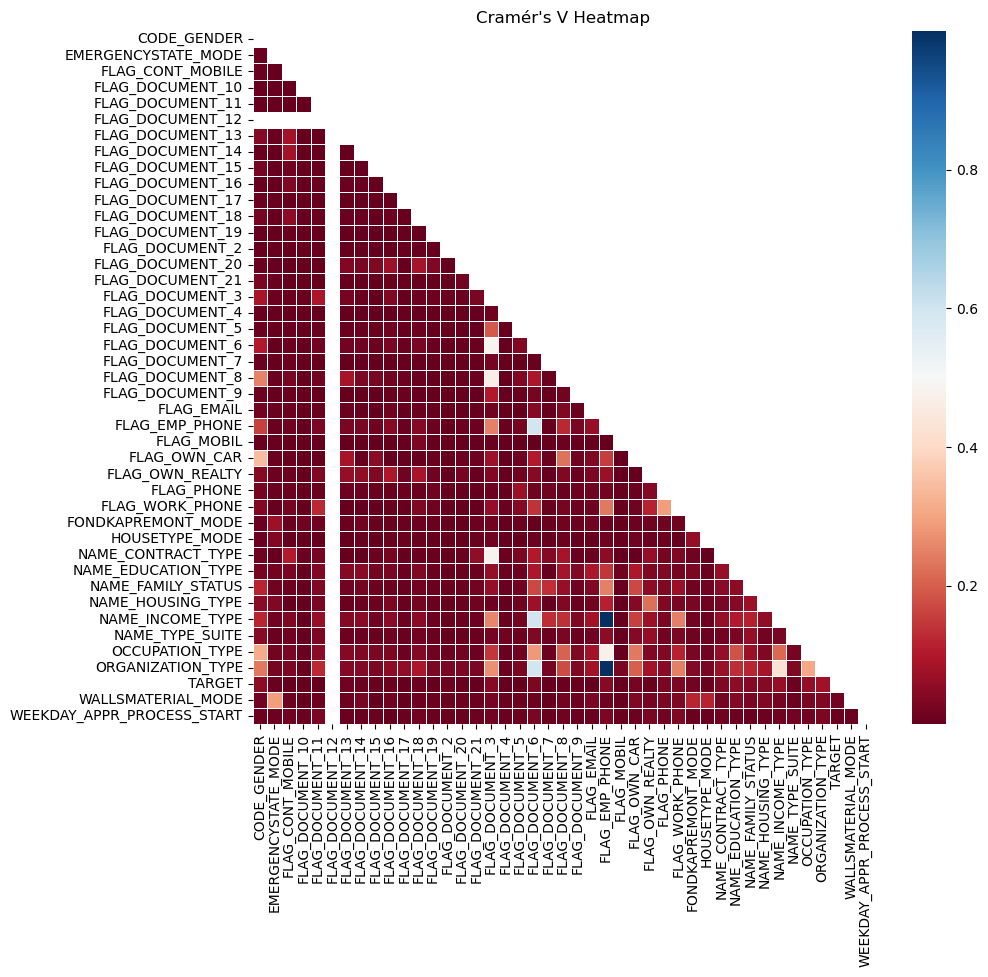

In [34]:
matrix = np.triu(correlation_matrix)

plt.figure(figsize=(10, 9))
sns.heatmap(correlation_matrix, annot=False, cmap="RdBu", fmt=".2f", linewidths=.5, mask=matrix)
plt.title("Cramér's V Heatmap");

The categorical features don't seem to correlate very well between each other. **No important correlations with our TARGET** were found.

'FLAG_DOCUMENT_12' only presents 0 values, hence the blank correlations.

<h3 style="color:#774CAD">Numerical</h3>

In [35]:
target = df_train["TARGET"]
num_imputer = SimpleImputer(strategy="median")

df_num = pd.DataFrame(num_imputer.fit_transform(df_train[num_feats]), columns=df_train[num_feats].columns)
df_num.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,115145.000,0.000,0.000,45000.000,180000.000,9000.000,180000.000,0.018,-8699.000,-1065.000,...,1.000,1.000,1.000,-1119.000,0.000,0.000,0.000,0.000,0.000,2.000
1,186243.000,0.000,1.000,157500.000,1183963.500,34749.000,927000.000,0.046,-15842.000,-1220.000,...,0.000,0.000,0.000,-861.000,0.000,0.000,0.000,0.000,0.000,3.000
2,237222.000,0.000,1.000,112500.000,1546020.000,40914.000,1350000.000,0.019,-13074.000,-2705.000,...,0.000,0.000,0.000,-1889.000,0.000,0.000,0.000,0.000,0.000,0.000
3,139662.000,0.000,0.000,225000.000,521280.000,26649.000,450000.000,0.031,-19909.000,-4159.000,...,1.000,1.000,1.000,-2467.000,0.000,0.000,0.000,0.000,1.000,4.000
4,118075.000,1.000,0.000,81000.000,454500.000,20151.000,454500.000,0.015,-17876.000,-377.000,...,0.000,0.000,0.000,-1725.000,0.000,0.000,0.000,0.000,0.000,5.000


In order to analyze the correlation of our target feature to the numerical ones we will calculate the **Point-biserial correlation**. Like the Pearson's Correlation Coeficient, it also **ranges between -1 and 1**, with 0 representing non-correlated values.

The correlation between the continuous features amongst themselves will be performed through person's correlation coefficient.

In [36]:
point_biserial_values = []

for col in df_num.columns:
    r, p_value = pointbiserialr(df_num[col], target)
    point_biserial_values.append((col, r, p_value))

point_biserial_df = pd.DataFrame(point_biserial_values, columns=['Feature', 'TARGET', 'P_Value']).set_index('Feature').rename_axis(index=None, columns=None)
point_biserial_df.loc['TARGET'] = 1
point_biserial_df.head()

,TARGET,P_Value
SK_ID_CURR,-0.003,0.227
TARGET,1.000,1.000
CNT_CHILDREN,0.018,0.000
AMT_INCOME_TOTAL,-0.018,0.000
AMT_CREDIT,-0.028,0.000


In [37]:
correlation_matrix = df_num.drop("TARGET", axis=1).corr()
correlation_matrix = correlation_matrix.merge(point_biserial_df['TARGET'], left_index=True, right_index=True)
correlation_matrix = pd.concat([correlation_matrix, point_biserial_df.drop('P_Value', axis=1).T], axis=0)
correlation_matrix.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TARGET
SK_ID_CURR,1.000,-0.001,0.001,-0.001,-0.001,-0.001,0.001,0.000,0.000,0.001,...,-0.002,0.001,-0.003,-0.002,-0.002,0.002,0.001,0.000,0.008,-0.003
CNT_CHILDREN,-0.001,1.000,0.026,0.005,0.023,0.001,-0.025,0.329,-0.239,0.185,...,0.013,0.001,-0.006,-0.002,-0.002,-0.002,-0.009,-0.003,-0.038,0.018
AMT_INCOME_TOTAL,0.001,0.026,1.000,0.326,0.399,0.332,0.157,0.058,-0.135,0.061,...,-0.023,-0.026,-0.043,0.003,0.004,0.006,0.057,0.016,0.032,-0.018
AMT_CREDIT,-0.001,0.005,0.326,1.000,0.769,0.987,0.099,-0.052,-0.070,0.009,...,0.003,-0.021,-0.074,-0.002,0.007,0.003,0.058,0.017,-0.039,-0.028
AMT_ANNUITY,-0.001,0.023,0.399,0.769,1.000,0.774,0.120,0.013,-0.108,0.041,...,-0.009,-0.023,-0.065,0.002,0.003,0.013,0.039,0.009,-0.012,-0.011


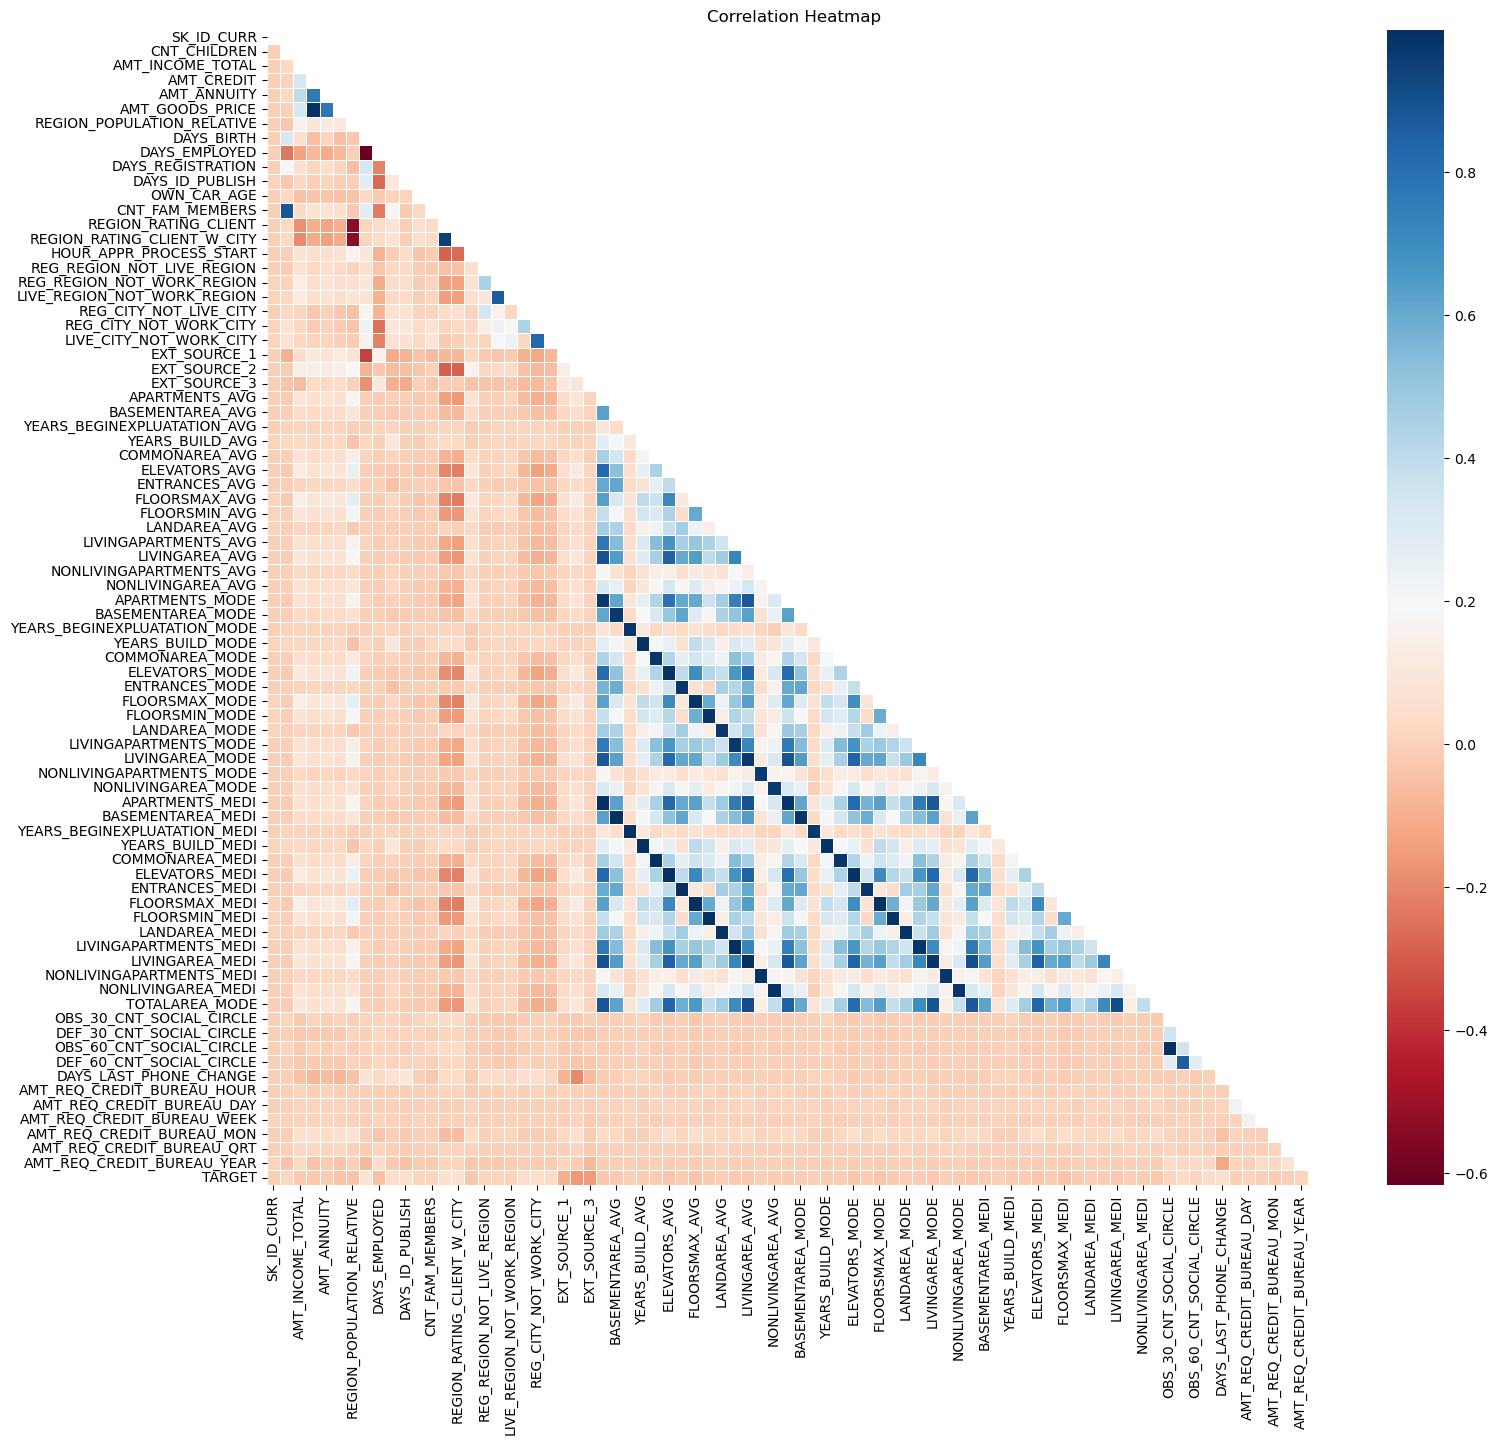

In [38]:
matrix = np.triu(correlation_matrix)

plt.figure(figsize=(17, 15))
sns.heatmap(correlation_matrix, annot=False, cmap="RdBu", fmt=".2f", linewidths=.5, mask=matrix)
plt.title("Correlation Heatmap");

Most of the continuous features also **don't appear to be correlated between themselves**. There are however **obvious correlations between features like BASEMENTAREA_AVG and BASEMENTAREA_MODE**, and in general between **areas of the houses of client**.

**Our TARGET is slightly more correlated to the EXT_SOURCE** features. These features represent Scores from external sources varying from 0 to 1 (normalized).

**These poor correlation results highlight** that some **feature engineering** processes will have to take place in order to obtain models with relevant results.

<h2 style="color:#774CAD">Exploration on Age and Employment Time</h2>

As we have seen before, the DAYS_ features present negative count of days in relation to the application date.

Let's quick check them and see if we can create some new relevant feature for our future model.

In [39]:
[col for col in df_train.columns if col.startswith('DAYS_')]

['DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'DAYS_LAST_PHONE_CHANGE']

In [40]:
(df_train['DAYS_BIRTH'] / -365).describe()

count   153755.000
mean        43.941
std         11.965
min         21.022
25%         34.004
50%         43.167
75%         53.959
max         69.121
Name: DAYS_BIRTH, dtype: float64

In [41]:
(df_train['DAYS_EMPLOYED'] / -365).describe()

count   153755.000
mean      -175.377
std        387.494
min      -1000.666
25%          0.795
50%          3.321
75%          7.548
max         49.074
Name: DAYS_EMPLOYED, dtype: float64

The **ranges for age seem to very correct** [21, 69].

When we look at **days employed**, however, we find already some **wrong values** (min -1000 years). The range seems to go from -1000 to 49 years of work.

In [42]:
df_train['DAYS_EMPLOYED'][df_train['DAYS_EMPLOYED'] > 0].value_counts()

DAYS_EMPLOYED
365243    27768
Name: count, dtype: int64

We see that all of these wrong values were actually filled with the same quantity of days (weird). We will **implement on our pipeline a conversion to NA and flag them as Anomalies**.

Let's further evaluate the other DAYS_ features.

In [43]:
(df_train['DAYS_REGISTRATION'] / -365).describe()

count   153755.000
mean        13.666
std          9.660
min         -0.000
25%          5.488
50%         12.345
75%         20.485
max         62.816
Name: DAYS_REGISTRATION, dtype: float64

Seems wierd a change in the registration 62 years before the application. It is however a possible value, and as I don't have a deeper understanding of the topic I will not flag this feature.

In [44]:
(df_train['DAYS_ID_PUBLISH'] / -365).describe()

count   153755.000
mean         8.195
std          4.139
min         -0.000
25%          4.701
50%          8.907
75%         11.775
max         19.718
Name: DAYS_ID_PUBLISH, dtype: float64

In [45]:
(df_train['DAYS_LAST_PHONE_CHANGE'] / -365).describe()

count   153754.000
mean         2.633
std          2.266
min         -0.000
25%          0.745
50%          2.066
75%          4.293
max         11.759
Name: DAYS_LAST_PHONE_CHANGE, dtype: float64

Everything seems ok for the last 2 features.

In this dataset (**financial datasets** in general), it is i**mportant to analyse the influence of age** on the target. We start then, by creating the column age in the dataframe and evaluating its distribution.

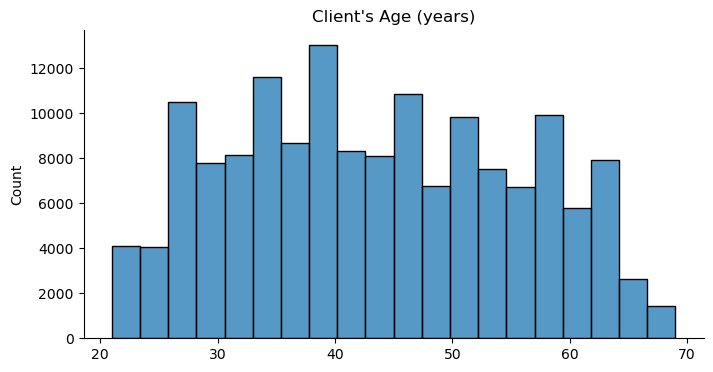

In [46]:
df_train['age'] = df_train['DAYS_BIRTH'] // - 365

fig, ax= plt.subplots(1, 1, figsize=(8, 4))
sns.histplot(df_train['age'], ax=ax, bins=20)
ax.set(xlabel="", title="Client's Age (years)")
sns.despine()

The **age follows a almost normal distribution** and there is not much to say about it. Let's try to find some patterns by **separating the ages in relation to the defaulters and non-defaulters**.

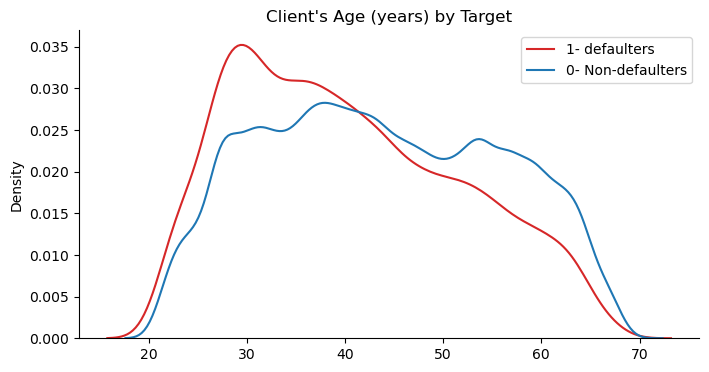

In [47]:
fig, ax= plt.subplots(1, 1, figsize=(8, 4))

sns.kdeplot(data=df_train, x='age', hue='TARGET', palette=['tab:blue', 'tab:red'], fill=False, common_norm=False)
ax.set(xlabel="", title="Client's Age (years) by Target")
plt.legend(labels=["1- defaulters", "0- Non-defaulters"])
sns.despine()

There seems to exist a **pattern of more defaulters for people of young age**, this could be an important feature to improve predictions on our dataset.
Let's divide by age groups.

In [48]:
print(df_train['age'].min(), df_train['age'].max())

21 69


So we create a bins for the age and we will plot them by the mean target by age group.

In [49]:
df_train['age_binned'] = pd.cut(df_train['age'], bins = np.linspace(20, 70, num = 11))

age_group = df_train[['TARGET', 'age_binned']].groupby('age_binned').mean()
age_group

,TARGET
age_binned,
"(20.0, 25.0]",0.112
"(25.0, 30.0]",0.115
"(30.0, 35.0]",0.099
"(35.0, 40.0]",0.087
"(40.0, 45.0]",0.079
"(45.0, 50.0]",0.073
"(50.0, 55.0]",0.065
"(55.0, 60.0]",0.054
"(60.0, 65.0]",0.051


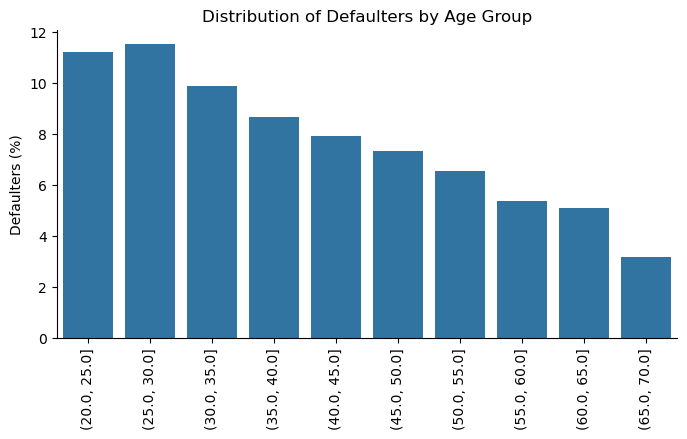

In [50]:
fig, ax= plt.subplots(1, 1, figsize=(8, 4))

sns.barplot(x=age_group.index.astype(str), y=age_group['TARGET']*100, ax=ax)
ax.set(xlabel="", ylabel="Defaulters (%)", title="Distribution of Defaulters by Age Group")
plt.xticks(rotation = 90)
sns.despine()

<h1 style="color:#774CAD">Partial Conclusions</h1>

In this notebook, we delved into the features of our Application Data. We opted to segregate the evaluation set exclusively from our original training data, as the test data lacked our target variable. This analysis offered valuable insights into the tasks that lie ahead and highlighted the significance of feature engineering for this dataset.

Our upcoming notebook will initiate a manual feature engineering process on our application data.